#  Logistic Regression with a Neural Network mindset

After completed the first course of Deep Learning Specialization on Coursera taught by Andrew Ng, I am implementing the algorithms on my own to retain the material taught.

In this first notebook, the logistic regression algorithm is applied in the MNIST dataset which can be found at http://yann.lecun.com/exdb/mnist/ or at https://www.kaggle.com/c/digit-recognizer/data. 

Since it is a multclass dataset I have had to do some research since multiclass problem wasn't covered in the first course.

However I've failed to implement it with softmax regression, so I decided to stick with the binary classification, by creating 10 weights, on for each of the classes.

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from load_data import loadData
%matplotlib inline


[7, 2, 3, 3, 8, 3, 7, 2, 7]


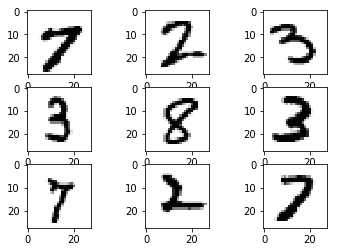

In [233]:
trainImages, trainLabels =  loadData("data/train-images-idx3-ubyte", "data/train-labels-idx1-ubyte")
testImages, testLabels =  loadData("data/t10k-images-idx3-ubyte", "data/t10k-labels-idx1-ubyte")

# Sanity check
assert trainImages.shape == (60000, 28, 28)
assert trainLabels.shape == (60000, )

assert testImages.shape == (10000, 28, 28)
assert testLabels.shape == (10000, )

labels = []
# plot 9 a random image with matplotlib and its labels for sanity check
for i in range(1, 10):
    index = np.random.choice(59999)
    labels.append(trainLabels[index])
    plt.subplot(330 + i)
    plt.imshow(trainImages[index], cmap='Greys')
print(labels)
plt.show()


In [234]:
# Get familiarized with the number of samples and shapes of the matrices 
m_train = len(trainImages)
m_test = len(testImages)
num_px = np.shape(trainImages[0])[0]

print("Number of Trainning examples m_train: ", m_train)
print("Number of test examples m_train: ", m_test)
print("Height and Widht of each image: ", num_px)
print("X - trainImages shape: ", np.shape(trainImages))
print("Y - trainLabels shape: ", np.shape(trainLabels))
print("X - testImages shape: ", np.shape(testImages))
print("Y - testLabels shape: ", np.shape(testLabels))


Number of Trainning examples m_train:  60000
Number of test examples m_train:  10000
Height and Widht of each image:  28
X - trainImages shape:  (60000, 28, 28)
Y - trainLabels shape:  (60000,)
X - testImages shape:  (10000, 28, 28)
Y - testLabels shape:  (10000,)


In [235]:
# Reshape the training and test examples
trainImagesFlatten = trainImages.reshape(m_train, -1).T
trainLabelsFlatten = trainLabels.reshape(1, trainLabels.shape[0])
testImagesFlatten = testImages.reshape(m_test, -1).T
testLabelsFlatten = testLabels.reshape(1, testLabels.shape[0])

print ("trainImagesFlatten shape: ", trainImagesFlatten.shape)
print ("trainLabelsFlatten shape: ", trainLabelsFlatten.shape)
print ("testImagesFlatten shape: ", testImagesFlatten.shape)
print ("testLabelsFlatten shape: ", testLabelsFlatten.shape)

# Standardize the dataset 
trainImages = trainImagesFlatten / 255
testImages = testImagesFlatten / 255
trainLabels = trainLabelsFlatten
testLabels = testLabelsFlatten

trainImagesFlatten shape:  (784, 60000)
trainLabelsFlatten shape:  (1, 60000)
testImagesFlatten shape:  (784, 10000)
testLabelsFlatten shape:  (1, 10000)


In [236]:
def initializeWeightsAndBias(dim):
    """
    This function creates a vector of random values of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector - number of parameters
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    np.random.seed(None)
    w = np.random.randn(dim, 1) * 0.01
    b = float(np.squeeze(np.random.randn(1)))
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [237]:
def sigmoid(z):
    """
    Compute the softmax of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- softmax(z)
    """
    return 1/(1 + np.exp(-z))

In [42]:
# Sanity check
W, b = initializeWeightsAndBias(trainImages.shape[0])
assert sigmoid(np.dot(W.T, trainImages) + b).shape == (W.T.shape[0], trainImages.shape[1]) 

In [238]:
def crossEntropy(A, Y):
    """
    This loss formula is used to compute loss of multiclass data
    A -- Computed softmax of the linear transformation on wigth vector and train images vector plus the bias
    of size (1, number of examples). 
    Y -- true "label" vector (containing 0, 1, 2 ... 10 ) of size (1, number of examples)
    
    Return:
    Loss -- Cross entropy loss -- - sum of hadamard
    """
    #loss = -np.divide(np.sum(np.multiply(Y, np.log(A, where=(A!=0)))), A.shape[1])
    #loss = -np.divide(np.sum(np.multiply(Y, np.log(A))), A.shape[1])
    #return loss
    return np.divide(np.sum(np.multiply(Y, np.log(A)) + np.multiply(1-Y,  np.log(1-A))), -60000) 
    

In [239]:
def forwardAndBackwardPropagation(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px,  1)
    b -- bias, a scalar
    X -- training images of size (num_px * num_px, number of examples)
    Y -- true "label" vector (containing 0, 1, 2 ... 10 ) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    # FORWARD PROPAGATION (FROM X TO COST)
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = crossEntropy(A, Y)
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(np.divide(X, m), np.subtract(A, Y).T)
    db = np.divide(np.sum(np.subtract(A, Y)), m)  

    cost = np.squeeze(cost)
    #assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost
    
    
    

In [240]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px, number of examples)
    Y -- true "label" vector of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = forwardAndBackwardPropagation(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [241]:
def predict(w, b, X):
    '''
    Predict whether the label is 0, 1, 2,3 ... 9 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0,1,..9) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    
    
    for i in range(A.shape[1]):
        if A[0,i] <= .5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [242]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
       
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
   
    w, b = initializeWeightsAndBias(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [243]:
numOfClasses = np.max(trainLabels)+1
modelInfoList = []
import time
tic = time.time()
for i in range(numOfClasses):
    print("Digit : " + str(i))
    trainLabelsCopy = np.copy(trainLabels)
    testLabelsCopy = np.copy(testLabels)
    trainLabelsCopy = (trainLabelsCopy == i).astype(int)
    testLabelsCopy = (testLabelsCopy == i).astype(int)
    d = model(trainImages, trainLabelsCopy, testImages, testLabelsCopy, num_iterations = 1000, learning_rate = 0.125, print_cost = True)
    modelInfoList.append(d)

toc = time.time()
print(toc - tic)

Digit : 0
Cost after iteration 0: 1.134267
Cost after iteration 100: 0.080782
Cost after iteration 200: 0.064046
Cost after iteration 300: 0.056592
Cost after iteration 400: 0.052130
Cost after iteration 500: 0.049072
Cost after iteration 600: 0.046805
Cost after iteration 700: 0.045035
Cost after iteration 800: 0.043600
Cost after iteration 900: 0.042404
train accuracy: 98.875 %
test accuracy: 99.1 %
Digit : 1
Cost after iteration 0: 0.418147
Cost after iteration 100: 0.068054
Cost after iteration 200: 0.053866
Cost after iteration 300: 0.048122
Cost after iteration 400: 0.044890
Cost after iteration 500: 0.042773
Cost after iteration 600: 0.041257
Cost after iteration 700: 0.040103
Cost after iteration 800: 0.039185
Cost after iteration 900: 0.038433
train accuracy: 98.895 %
test accuracy: 99.18 %
Digit : 2
Cost after iteration 0: 0.452303
Cost after iteration 100: 0.125251
Cost after iteration 200: 0.106076
Cost after iteration 300: 0.097875
Cost after iteration 400: 0.093089
Cost a

Number:  3
Probability: 
61.01983992352154 %
Predicted: 
100.0 %
Number:  6
Probability: 
26.50390892311057 %
Predicted: 
100.0 %
Number:  6
Probability: 
25.829342132942894 %
Predicted: 
100.0 %
Number:  1
Probability: 
23.171942607543375 %
Predicted: 
100.0 %
Number:  5
Probability: 
36.362920091007645 %
Predicted: 
0.0 %
Number:  9
Probability: 
22.18039862795153 %
Predicted: 
100.0 %
Number:  7
Probability: 
42.35594746448978 %
Predicted: 
0.0 %
Number:  0
Probability: 
52.173681064698926 %
Predicted: 
100.0 %
Number:  2
Probability: 
17.816427709631455 %
Predicted: 
100.0 %


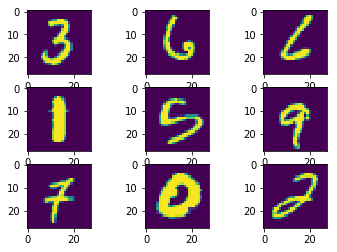

In [245]:
for i in range(1, 10):
    index = np.random.choice(testLabels.shape[1])
    n = testLabels[0, index]
    w = modelInfoList[n]['w']
    b = modelInfoList[n]['b']
    X = testImages[:, [index]]
    p = predict(w, b, X)
    print("Number: ", testLabels[0, index])
    print("Probability: ")
    print(np.squeeze(sigmoid(np.dot(W.T, X) + b)) * 100, "%")
    print("Predicted: ")
    print(np.squeeze(p)*100, "%")
    plt.subplot(330 + i)
    plt.imshow(X.reshape(28,28))


Number:  0
[1.1342671  0.0807824  0.06404632 0.05659171 0.0521297  0.04907243
 0.04680547 0.04503479 0.04359981 0.04240444]


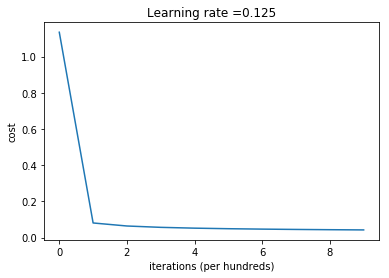

Number:  1
[0.41814741 0.06805411 0.05386603 0.04812225 0.04488992 0.04277331
 0.04125671 0.04010255 0.03918545 0.03843273]


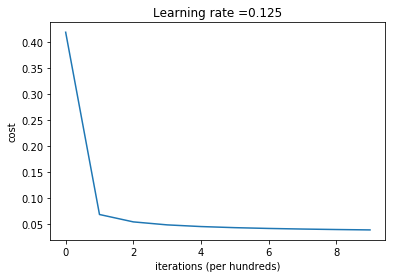

Number:  2
[0.45230251 0.12525104 0.10607581 0.09787467 0.0930893  0.08986466
 0.0875026  0.08567608 0.0842092  0.08299785]


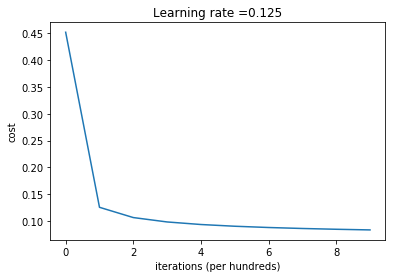

Number:  3
[2.02063321 0.16368039 0.13903054 0.12830748 0.12189895 0.11744911
 0.11408028 0.11138557 0.109148   0.10723984]


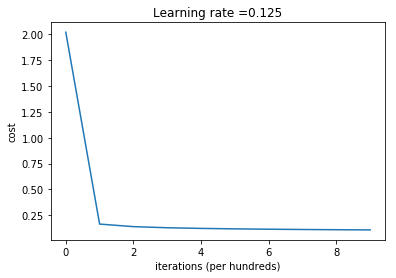

Number:  4
[0.48763449 0.11628736 0.09464865 0.08512651 0.07955348 0.07582804
 0.07313301 0.07107715 0.06944744 0.06811718]


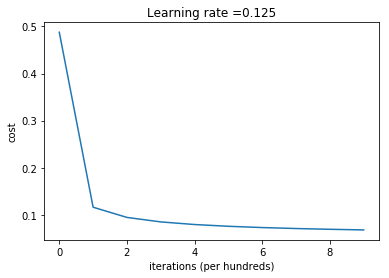

Number:  5
[0.55186814 0.16381276 0.14027279 0.12973205 0.12352741 0.11934269
 0.11627675 0.11390179 0.11198725 0.11039718]


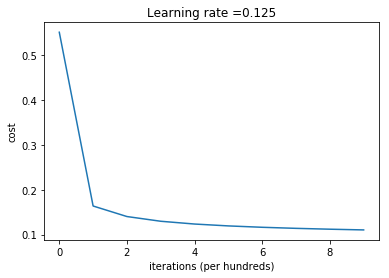

Number:  6
[0.55636408 0.08945415 0.07131386 0.0639032  0.0596867  0.05690168
 0.0548965  0.05336844 0.05215585 0.05116378]


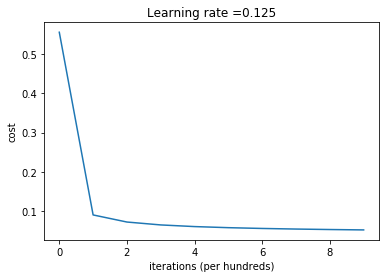

Number:  7
[0.73146073 0.0949661  0.07868874 0.07196637 0.06808061 0.06546953
 0.06355927 0.06208376 0.0609004  0.0599248 ]


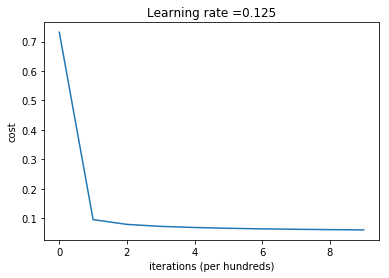

Number:  8
[0.62508212 0.20621178 0.18262886 0.17141065 0.16421331 0.15892824
 0.15475264 0.1513062  0.14838047 0.14584853]


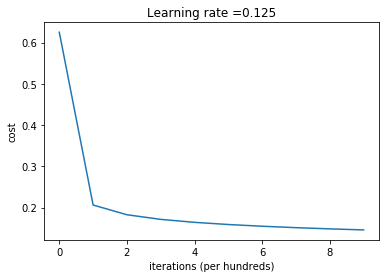

Number:  9
[0.60201804 0.17372535 0.15050011 0.13967866 0.13322946 0.12886495
 0.12566938 0.12320112 0.12121955 0.11958179]


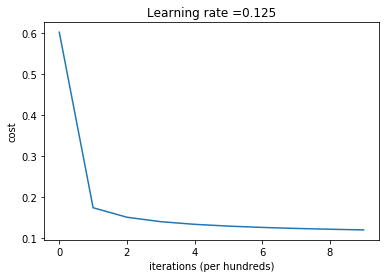

In [246]:
for i in range(0, 10):
    print("Number: ", i)
    costs = np.squeeze(modelInfoList[i]['costs'])
    print(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(d["learning_rate"]))

    plt.show()

In [247]:
count = 0
for i in range(10000):
    index = np.random.choice(testLabels.shape[1])
    n = testLabels[0, index]
    w = modelInfoList[n]['w']
    b = modelInfoList[n]['b']
    X = testImages[:, [index]]
    p = predict(w, b, X)
    count += np.squeeze(p)
print(count)

8278.0
